Data: 1785 rows
Training model...
Epoch [1/150] Train: 0.541110, Val: 0.713339
Epoch [20/150] Train: 0.373752, Val: 0.697642
Epoch [40/150] Train: 0.357691, Val: 0.696481
Epoch [60/150] Train: 0.355401, Val: 0.700143
Early stopping at epoch 74
Model trained!

Starting prediction from: 2025-12-19
Current price: $273.67

Day  5 (2025-12-26): $274.23
Day 10 (2026-01-02): $274.56
Day 15 (2026-01-09): $274.75
Day 20 (2026-01-16): $274.84
Day 25 (2026-01-23): $274.81
Day 30 (2026-01-30): $274.79


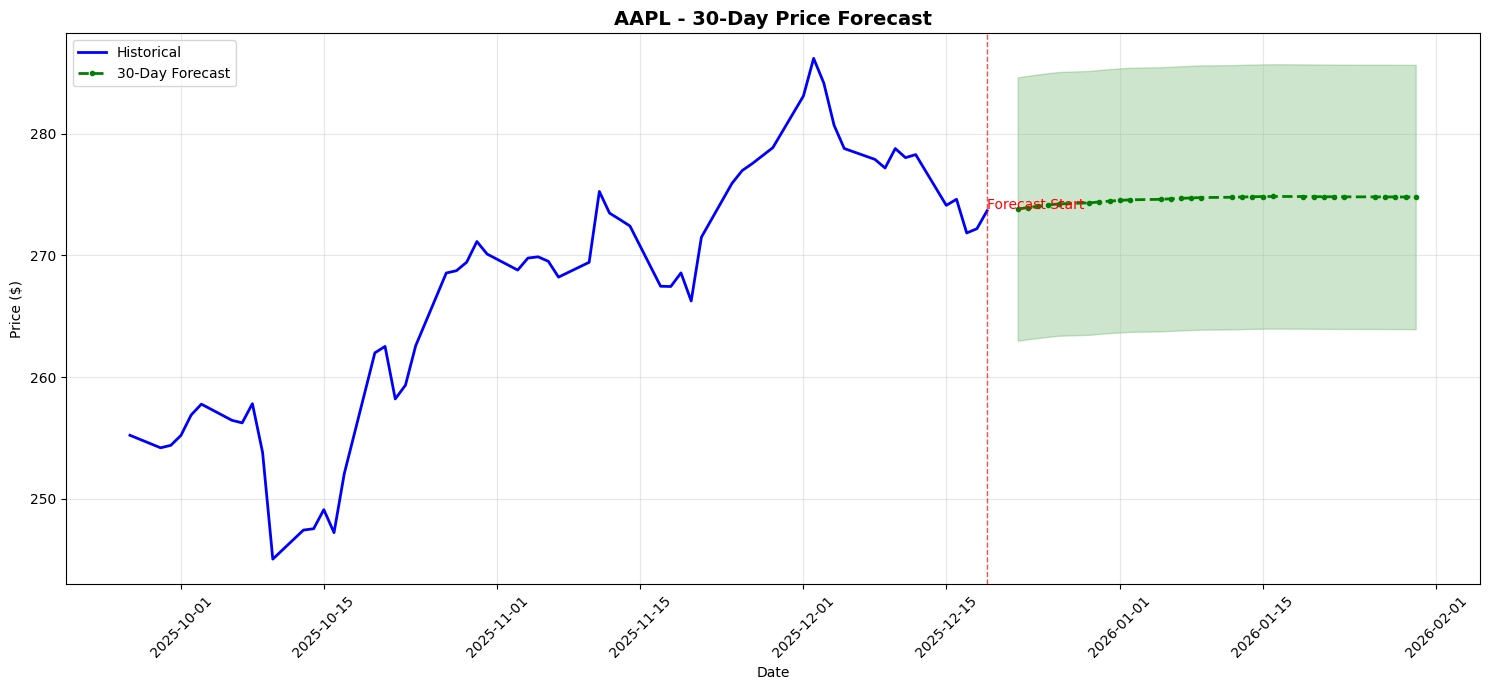


30-DAY FORECAST SUMMARY
Current Price: $273.67
Predicted Price (Day 30): $274.79
Expected Change: $1.12 (0.41%)

Forecast saved to: c:\Users\soltv\Documents\GitHub\newalgotrade\data\predictions\30_day_forecast.csv

First 10 days forecast:
            Predicted_Price  Upper_Bound  Lower_Bound
Date                                                 
2025-12-22       273.806381   284.629661   262.983100
2025-12-23       273.929281   284.757419   263.101142
2025-12-24       274.038967   284.871442   263.206493
2025-12-25       274.138540   284.974950   263.302129
2025-12-26       274.228473   285.068438   263.388507
2025-12-29       274.312370   285.155651   263.469088
2025-12-30       274.390934   285.237322   263.544547
2025-12-31       274.458132   285.307175   263.609088
2026-01-01       274.514544   285.365818   263.663271
2026-01-02       274.563558   285.416770   263.710347

Last 10 days forecast:
            Predicted_Price  Upper_Bound  Lower_Bound
Date                              

In [7]:
# ============================================
# FUTURE PREDICTION - Next 30 Days
# ============================================

from pathlib import Path
import sqlite3
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = Path(os.getcwd()).parent

import importlib.util
spec = importlib.util.spec_from_file_location("config", BASE_DIR / "config.py")
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

TICKER = config.TICKER

# ====================
# 1. LOAD DATA + FEATURES
# ====================
sqlite_path = BASE_DIR / "data" / "processed" / "data_processed.sqlite"

with sqlite3.connect(sqlite_path) as conn:
    df = pd.read_sql("SELECT Date, Open, High, Low, Close, Volume FROM data ORDER BY Date;", conn, parse_dates=["Date"])

df.set_index("Date", inplace=True)

# Technical indicators
df['returns'] = df['Close'].pct_change()
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

for period in [5, 10, 20]:
    df[f'MA{period}'] = df['Close'].rolling(period).mean()
    df[f'MA{period}_ratio'] = df['Close'] / df[f'MA{period}']

df['volatility_5'] = df['returns'].rolling(5).std()
df['volatility_20'] = df['returns'].rolling(20).std()

df['volume_ma10'] = df['Volume'].rolling(10).mean()
df['volume_ratio'] = df['Volume'] / df['volume_ma10']

df['high_low_pct'] = (df['High'] - df['Low']) / df['Close']
df['close_open_pct'] = (df['Close'] - df['Open']) / df['Open']

df['price_diff'] = df['Close'].diff()

df = df.dropna()
print(f"Data: {len(df)} rows")

# ====================
# 2. PREPARE DATA
# ====================
feature_cols = ['Close', 'Volume', 'returns', 'log_returns', 'volatility_5', 'volatility_20',
                'MA5_ratio', 'MA10_ratio', 'MA20_ratio', 'volume_ratio', 
                'high_low_pct', 'close_open_pct']

X = df[feature_cols].values
y = df['price_diff'].values
close_prices = df['Close'].values
dates = df.index

scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

train_size = int(len(X_scaled) * 0.8)

def create_sequences(X, y, close, seq_length):
    xs, ys, closes = [], [], []
    for i in range(len(X) - seq_length - 1):
        xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
        closes.append(close[i+seq_length])
    return np.array(xs), np.array(ys), np.array(closes)

seq_length = 20
X_train_raw, y_train_raw, _ = create_sequences(X_scaled[:train_size], y_scaled[:train_size], 
                                                 close_prices[:train_size], seq_length)
X_test_raw, y_test_raw, test_closes = create_sequences(X_scaled[train_size:], y_scaled[train_size:],
                                                        close_prices[train_size:], seq_length)

X_train_t = torch.from_numpy(X_train_raw).float().to(device)
y_train_t = torch.from_numpy(y_train_raw).float().to(device).unsqueeze(1)
X_test_t = torch.from_numpy(X_test_raw).float().to(device)
y_test_t = torch.from_numpy(y_test_raw).float().to(device).unsqueeze(1)

# ====================
# 3. MODEL
# ====================
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context

class BiLSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size=80, num_layers=3, dropout=0.3):
        super().__init__()
        
        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        self.attention = Attention(hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        
        self.fc3 = nn.Linear(hidden_size // 2, 1)
    
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = self.layer_norm1(lstm_out)
        
        context = self.attention(lstm_out)
        
        out = self.fc1(context)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out

model = BiLSTMAttention(input_size=X_train_raw.shape[2], hidden_size=80, num_layers=3).to(device)

# ====================
# 4. TRAINING
# ====================
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

num_epochs = 150
best_loss = float('inf')
patience_counter = 0

print("Training model...")
for epoch in range(1, num_epochs + 1):
    model.train()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_bilstm_future.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= 30:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}] Train: {loss.item():.6f}, Val: {val_loss.item():.6f}")

model.load_state_dict(torch.load('best_bilstm_future.pth'))
print("Model trained!\n")

# ====================
# 5. PREDICT NEXT 30 DAYS
# ====================
model.eval()

# Start with last 20 days of actual data
last_sequence = X_scaled[-seq_length:].copy()
current_price = close_prices[-1]
last_date = dates[-1]

future_predictions = []
future_dates = []

print(f"Starting prediction from: {last_date.strftime('%Y-%m-%d')}")
print(f"Current price: ${current_price:.2f}\n")

for day in range(1, 31):
    # Predict next day
    seq_tensor = torch.from_numpy(last_sequence.reshape(1, seq_length, -1)).float().to(device)
    
    with torch.no_grad():
        pred_diff_scaled = model(seq_tensor).cpu().numpy().flatten()[0]
    
    # Inverse transform
    pred_diff = scaler_y.inverse_transform([[pred_diff_scaled]])[0][0]
    
    # Calculate next price
    next_price = current_price + pred_diff
    future_predictions.append(next_price)
    
    # Generate next date (business days)
    next_date = last_date + pd.Timedelta(days=1)
    while next_date.weekday() >= 5:  # Skip weekends
        next_date += pd.Timedelta(days=1)
    future_dates.append(next_date)
    
    # Update sequence with predicted values
    # Calculate new features based on prediction
    new_features = np.zeros(len(feature_cols))
    new_features[0] = next_price  # Close
    new_features[1] = df['Volume'].iloc[-1]  # Use last known volume
    new_features[2] = (next_price - current_price) / current_price  # returns
    new_features[3] = np.log(next_price / current_price)  # log_returns
    
    # For other features, use approximations
    new_features[4] = df['volatility_5'].iloc[-1]
    new_features[5] = df['volatility_20'].iloc[-1]
    
    # MA ratios - approximate
    new_features[6] = next_price / df['MA5'].iloc[-1]
    new_features[7] = next_price / df['MA10'].iloc[-1]
    new_features[8] = next_price / df['MA20'].iloc[-1]
    
    new_features[9] = 1.0  # volume_ratio
    new_features[10] = df['high_low_pct'].iloc[-1]
    new_features[11] = 0.0  # close_open_pct
    
    # Scale new features
    new_features_scaled = scaler_X.transform(new_features.reshape(1, -1))[0]
    
    # Shift sequence
    last_sequence = np.vstack([last_sequence[1:], new_features_scaled])
    
    # Update for next iteration
    current_price = next_price
    last_date = next_date
    
    if day % 5 == 0:
        print(f"Day {day:2d} ({next_date.strftime('%Y-%m-%d')}): ${next_price:.2f}")

# ====================
# 6. VISUALIZATION
# ====================
# Combine historical and future
historical_dates = dates[-60:]  # Last 60 days
historical_prices = close_prices[-60:]

fig, ax = plt.subplots(figsize=(15, 7))

# Plot historical
ax.plot(historical_dates, historical_prices, label="Historical", color="blue", linewidth=2)

# Plot future predictions
ax.plot(future_dates, future_predictions, label="30-Day Forecast", 
        color="green", linewidth=2, linestyle='--', marker='o', markersize=3)

# Add confidence band (simple approximation)
volatility = df['returns'].std()
upper_bound = np.array(future_predictions) * (1 + 2 * volatility)
lower_bound = np.array(future_predictions) * (1 - 2 * volatility)

ax.fill_between(future_dates, lower_bound, upper_bound, alpha=0.2, color='green')

# Vertical line at prediction start
ax.axvline(x=dates[-1], color='red', linestyle='--', linewidth=1, alpha=0.7)
ax.text(dates[-1], ax.get_ylim()[1]*0.95, 'Forecast Start', rotation=0, color='red')

ax.set_title(f"{TICKER} - 30-Day Price Forecast", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ====================
# 7. SAVE PREDICTIONS
# ====================
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions,
    'Upper_Bound': upper_bound,
    'Lower_Bound': lower_bound
})

forecast_df.set_index('Date', inplace=True)

out_path = BASE_DIR / "data" / "predictions" / "30_day_forecast.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
forecast_df.to_csv(out_path)

print(f"\n{'='*60}")
print("30-DAY FORECAST SUMMARY")
print(f"{'='*60}")
print(f"Current Price: ${close_prices[-1]:.2f}")
print(f"Predicted Price (Day 30): ${future_predictions[-1]:.2f}")
print(f"Expected Change: ${future_predictions[-1] - close_prices[-1]:.2f} ({(future_predictions[-1]/close_prices[-1]-1)*100:.2f}%)")
print(f"\nForecast saved to: {out_path}")
print(f"{'='*60}\n")

print("First 10 days forecast:")
print(forecast_df.head(10))

print("\nLast 10 days forecast:")
print(forecast_df.tail(10))